# Transformation Equations:  ComCam DP1 <--> SDSS DR18

_Meagan N. Porter, Douglas L. Tucker, Christina L. Adair_

_2025.6.29_

## 1. Import Modules

In [1]:
import numpy as np
import pandas as pd

from lsst.daf.butler import Butler
import lsst.geom as geom

import pyvo

import os
import sys
import glob
import math
import datetime

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt

%matplotlib inline

## 2. Input Parameters

In [2]:
# ComCam-->SDSS DR18 (toComCam=False) or SDSS DR18-->ComCam (toComCam=True)...
toComCam = True
#toComCam = False

if toComCam:
    # List of ComCam bands on which to run the transform fit...
    #bandList = ['g_ComCam', 'r_ComCam', 'i_ComCam', 'z_ComCam', 'y_ComCam']
    bandList = ['g_ComCam', 'r_ComCam', 'i_ComCam', 'z_ComCam', 'gi_ComCam']
    # If SDSS-->ComCam, then the mag and color to fit against are SDSS...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_ComCam':'g_sdss', 'r_ComCam':'r_sdss', 'i_ComCam':'i_sdss', 'z_ComCam':'z_sdss', 'y_ComCam':'z_sdss', 'gi_ComCam':'gi_sdss'}
    # Color to fit against...
    color_name_1_dict = {'g_ComCam':'gi_sdss', 'r_ComCam':'gi_sdss', 'i_ComCam':'gi_sdss', 'z_ComCam':'gi_sdss', 'y_ComCam':'gi_sdss', 'gi_ComCam':'gi_sdss'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_ComCam':'$(g-i)_{sdss}$', 'r_ComCam':'$(g-i)_{sdss}$', 'i_ComCam':'$(g-i)_{sdss}$', 'z_ComCam':'$(g-i)_{sdss}$', 'y_ComCam':'$(g-i)_{sdss}$', 'gi_ComCam':'$(g-i)_{sdss}$'}
    # Color limits defining disjoint branches of the dmag vs. color plots
    #  (each branch will be fit separately)...
    color_limits_1_dict = {'g_ComCam':[-10.,10.], 
                           'r_ComCam':[-10.,10.], 
                           'i_ComCam':[-10.,10.],
                           'z_ComCam':[-10.,10.],
                           'y_ComCam':[-10.,10.],
                           'gi_ComCam':[-10.,10.]
                          }
    
    
else:
    # List of SDSS bands on which to run the transform fit...
    bandList = ['g_sdss', 'r_sdss', 'i_sdss', 'z_sdss','gi_sdss']
    # If ComCam-->SDSS, then the mag and color to fit against are ComCam...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_sdss':'g_ComCam', 'r_sdss':'r_ComCam', 'i_sdss':'i_ComCam', 'z_sdss':'z_ComCam', 'y_sdss':'z_ComCam', 'gi_sdss':'gi_ComCam'}
    # Color to fit against...
    color_name_1_dict = {'g_sdss':'gi_ComCam', 'r_sdss':'gi_ComCam', 'i_sdss':'gi_ComCam', 'z_sdss':'gi_ComCam', 'y_sdss':'gi_ComCam', 'gi_sdss':'gi_ComCam'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_sdss':'$(g-i)_{ComCam}$', 'r_sdss':'$(g-i)_{ComCam}$', 'i_sdss':'$(g-i)_{ComCam}$', 'z_sdss':'$(g-i)_{ComCam}$', 'y_sdss':'$(g-i)_{ComCam}$', 'gi_sdss':'$(g-i)_{ComCam}$'}
    # Color limits defining disjoint branches of the dmag vs. color plots
    #  (each branch will be fit separately)...    
    color_limits_1_dict = {'g_sdss':[-10.,10.], 
                           'r_sdss':[-10.,10.], 
                           'i_sdss':[-10.,10.],
                           'z_sdss':[-10.,10.],
                           'gi_sdss':[-10., 10.]
                          }

# Order of polynomial fits...
norder = 1

# Sigma-clipping parameters...
nsigma = 3.0
niter = 3

# ComCam data
collection='LSSTComCam/DP1'
repo = 'dp1'
skymap = 'lsst_cells_v1'
instrument = 'LSSTComCam'

# Name of the SDSS file (if it exists)
sdssFile = '/home/d/dltucker/DATA/LSST_DP1_AREAS_2_dtucker.csv'
    
#use match file?
useMatchFile = False

# Name of the match file
#matchFile = '/home/d/dltucker/DATA/match.comcam_stars_all.w_2025_10.DM-49359a.SDSS_DR18.csv'
matchFile = '/home/d/dltucker/DATA/match.comcam_stars_all.DP1.SDSS_DR18.csv'

# Base name of fit results output file...
#if toComCam:
#    resultsFileBaseName = 'transFit.PS1DR2_to_ComCam'
#else:
#    resultsFileBaseName = 'transFit.ComCam_to_PS1DR2'

# Base name of QA plot output files...
if toComCam:
    qaFileBaseName = 'qaPlot.SDSS_to_ComCam.fit'
else:
    qaFileBaseName = 'qaPlot.ComCam_to_SDSS.fit'

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2


# From Slide 9 of https://docs.google.com/presentation/d/1NGzrT4t6wDGQ2-2a8rjioToquhx2vOP_KJTrPiCrDDY/edit#slide=id.g33de3f5c849_6_250
tract_list = [453, 454, 4849, 5063, 4848, 2394, 2234, 4016, 4017, 4218, 4217, 5525, 5526, 7611, 7610, 7850, 10463, 10464, 10704]
tract_dict={453: '47 Tuc', 
            454: '47 Tuc',
           4849: 'ECDFS', 
           5063: 'ECDFS',
           4848: 'ECDFS', 
           2394: 'EDFS', 
           2234: 'EDFS',
           4016: 'Fornax', 
           4017: 'Fornax', 
           4218: 'Fornax', 
           4217: 'Fornax', 
           5525: 'Rubin_SV_095-25', 
           5526: 'Rubin_SV_095-25', 
           7611: 'Seagull', 
           7610: 'Seagull', 
           7850: 'Seagull',
           10463: 'Rubin_SV_38_7', 
           10464: 'Rubin_SV_38_7', 
           10704: 'Rubin_SV_38_7'
           }

## 3. Define Useful Functions

In [3]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
def cross_match_catalogs(df1, df2, ra_name_1, dec_name_1, ra_name_2, dec_name_2):

    # Create SkyCoord objects for both dataframes
    coords1 = SkyCoord(ra=df1[ra_name_1].values*u.degree, 
                       dec=df1[dec_name_1].values*u.degree)

    coords2 = SkyCoord(ra=df2[ra_name_2].values*u.degree, 
                       dec=df2[dec_name_2].values*u.degree)

    # Match coordinates
    max_sep = 3 * u.arcsec  # Maximum separation
    idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)

    # Create mask for matches within max_sep
    mask = d2d < max_sep

    # Additional mask to ensure indices are valid
    valid_idx_mask = idx[mask] < len(df2)
    combined_mask = mask.copy()
    combined_mask[mask] = valid_idx_mask
    
    # Create a new dataframe with matches
    matches = df1[combined_mask].copy()
    matches['match_idx'] = idx[combined_mask]  # Index of matching object in df2
    matches['separation_arcsec'] = d2d[combined_mask].arcsec  # Separation in arcseconds

    # Add columns from df2 for the matches
    for col in df2.columns:
        #matches[f'match_{col}'] = df2.loc[idx[mask], col].values
        # This is a safer way to to this, avoid out-of-bound indices:
        matches[f'match_{col}'] = df2.iloc[idx[combined_mask]][col].values

    # If multiple matches exist for the same source in df1, keep only the closest one
    matches = matches.loc[matches.groupby(matches.index)['separation_arcsec'].idxmin()]

    # If you want to see which objects in df1 had no matches:
    unmatched = df1[~combined_mask]

    return matches, unmatched

In [5]:
def transform1ColorQAPlots1a(dmag, color1, res, norder, title, plotText, dmagName, colorLabel1, rms, outputFileName):

    # Prepare QA plots...
    #fig = plt.figure(figsize=(10,5))
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")
    plt.rcParams.update({'font.size': 24})
    
    # We will exclude the lowest and highets 0.01% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    dmag_desc = dmag.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #res_desc = df.res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    res_desc = res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #color1_min = color1_desc['1%']
    #color1_max = color1_desc['99%']
    #color1_min = color1_desc['min']
    #color1_max = color1_desc['max']
    #dmag_min = dmag_desc['1%']
    #dmag_max = dmag_desc['99%']
    #res_min = res_desc['1%']
    #res_max = res_desc['99%']
    color1_min = color1_desc['0.01%']
    color1_max = color1_desc['99.99%']
    dmag_min = dmag_desc['0.01%']
    dmag_max = dmag_desc['99.99%']
    res_min = res_desc['0.01%']
    res_max = res_desc['99.99%']
    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    #res_min = -0.10
    #res_max = +0.10

    
    # Plot 1:  Descriptive text...
    #plt.subplot(231)
    plt.subplot(221)
    plt.text(0.1,0.80,title,fontsize=24)
    plt.text(0.00,0.40,plot1Text,fontsize=12)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    #plt.subplot(232) 
    plt.subplot(222)
    if len(dmag) < 1000:
        plt.scatter(color1, dmag, alpha=0.75)
        #hb=plt.hexbin(color1, dmag, gridsize=100, cmap='inferno_r')
    else:
        hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    if len(dmag) >= 1000:
        cb = fig.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(color='blue')
    plt.grid(True)


    # Plot 3:  1d histogram of residuals...
    #plt.subplot(234) 
    plt.subplot(223) 
    #plt.hist(df.loc[:,'res'],bins=100)
    if len(res) < 100:
        plt.hist(res,bins=10)
    else:
        plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='blue')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    #plt.subplot(235) 
    plt.subplot(224)
    if len(res) < 1000:
        plt.scatter(color1, res, alpha=0.75)
        #hb = plt.hexbin(color1, res, gridsize=100, cmap='inferno_r')
    else:
        hb = plt.hexbin(color1, res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    if len(res) >= 1000:
        cb = plt.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(True)
    plt.grid(color='blue')

    
    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################


In [6]:
# Kudos to Claude-3.5-Sonnet for improving on old outlier rejection code...

def poly_fit_with_sigma_clip(x, y, degree=1, sigma=3.0, maxiters=5):
    """
    Perform polynomial fit with iterative sigma clipping
    
    Parameters:
    -----------
    x : array-like
        Independent variable
    y : array-like 
        Dependent variable
    degree : int
        Degree of polynomial fit
    sigma : float
        Sigma clipping threshold
    maxiters : int
        Maximum number of sigma clipping iterations
        
    Returns:
    --------
    coeffs : array
        Polynomial coefficients
    mask : array
        Boolean mask indicating non-clipped points
    rms : float
        RMS of residuals
    """

    # Import relevant modules
    import numpy as np
    from astropy.stats import sigma_clip
    
    # Initial fit using all points
    x = np.asarray(x)
    y = np.asarray(y)
    mask = np.ones_like(x, dtype=bool)
    
    for _ in range(maxiters):
        print(len(x[mask]), len(y[mask]), len(mask))

        # Fit polynomial to non-masked points
        coeffs, cov = np.polyfit(x[mask], y[mask], degree, cov=True)
        
        # Calculate residuals
        yfit = np.polyval(coeffs, x)
        residuals = y - yfit
        
        # Update mask with sigma clipping
        new_mask = ~sigma_clip(residuals, sigma=sigma).mask
        
        # Check for convergence
        if np.array_equal(mask, new_mask):
            break
        
        mask = new_mask
    
    # Calculate final RMS
    final_residuals = y[mask] - np.polyval(coeffs, x[mask])
    rms = np.sqrt(np.mean(final_residuals**2))

    print(len(x[mask]), len(y[mask]), len(mask))

    # Calculate coefficient errors from diagonal of covariance matrix
    coeff_errors = np.sqrt(np.diag(cov))
        
    return coeffs, coeff_errors, x[mask], y[mask], final_residuals, rms

## X. Read in Matched Catalog

In [7]:
#matchFile = os.path.join(matchDir,matchFile)
#print(matchFile)

In [8]:
## Check to make sure matchFile exists...
if useMatchFile:
    if os.path.isfile(matchFile)==False:
        print("""ERROR:  matchFile %s does not exist...""" % (matchFile))
    if verbose > 0:
        print('matchFile: ', matchFile)


In [9]:
if useMatchFile:
    tab = Table.read(matchFile, format='csv')
    display(tab)

In [10]:
if useMatchFile:
    matches = tab.to_pandas()
    display(matches)

## 4. Query ComCam Catalog

In [11]:
# Create two butlers, one including the skymap.
#  (Creating two should not be necessary, but...)
if not useMatchFile:
    butler = Butler(repo, collections=collection)
    skybutler = Butler(repo, collections=collection, skymap=skymap)

In [12]:
# Define which of the nearly 1000 columns to download from the ComCam ObjectTable...
if not useMatchFile:
    INCOLS = [
        'coord_ra',
        'coord_dec',
    ]
    bands="ugrizy"
    for band in bands:
        INCOLS += [
            f'{band}_psfFlux',
            f'{band}_psfFluxErr',
            f'{band}_ap12Flux',
            f'{band}_ap12FluxErr',
            f'{band}_extendedness',
            f'{band}_psfFlux_flag'
        ]


In [13]:
# Download all DP1 stars with SNR>5 in the r-band psfFluxstars...
if not useMatchFile:
    comcam_stars_list = []
    ra_min = {}
    ra_max = {}
    dec_min = {}
    dec_max = {}


    for tractId in tract_list:

        print(tractId, tract_dict[tractId])

        try:
    
            raw_comcam = butler.get('object', dataId={'skymap': 'lsst_cells_v1', 'tract': tractId}, 
                                    collections=[collection],
                                    parameters={"columns":INCOLS}).to_pandas()

            # Insert tractId as the first column
            raw_comcam.insert(0, 'tractId', tractId)  
    
            # Insert field name -- if known -- as the second column
            if tractId in tract_dict:
                field = tract_dict[tractId]
            else:
                field = 'unknown'
            raw_comcam.insert(1, 'field', field)  

            # Clean the catalog
            #sel  = (raw_comcam['detect_isPrimary'] == True)
            sel = (raw_comcam['r_psfFlux']/raw_comcam['r_psfFluxErr'] > 5)
            for band in ['g','r','i']:
                sel &= (raw_comcam[f'{band}_psfFlux_flag'] == 0)

            comcam = raw_comcam[sel]

            # Find just the (most likely) stars...
            sel_comcam_stars = (comcam['g_extendedness'] < 0.5) & (comcam['r_extendedness'] < 0.5)
            comcam_stars = comcam[sel_comcam_stars] 
            print(f"Number of objects: {len(comcam)}")
            print(f"Number of stars: {len(comcam_stars)}")

            # Find the bounding (ra,dec)'s for each DP1 tractId: 
            ra_min[tractId] = comcam_stars.coord_ra.min()
            ra_max[tractId] = comcam_stars.coord_ra.max()
            dec_min[tractId] = comcam_stars.coord_dec.min()
            dec_max[tractId] = comcam_stars.coord_dec.max()
            print(tractId, ra_min[tractId], ra_max[tractId], dec_min[tractId], dec_max[tractId])

            # Append the dataframe to the list
            comcam_stars_list.append(comcam_stars) 

        # Catch any exception
        except Exception as e:

            print(f"An error occurred for tractId {tractId}: {e}")


    # Concatenate all dataframes in the list
    comcam_stars_all = pd.concat(comcam_stars_list, ignore_index=True)  
    print(f"Total number of stars: {len(comcam_stars_all)}")


453 47 Tuc
Number of objects: 49962
Number of stars: 9872
453 4.339320403393294 6.9230561484409705 -72.66605865167178 -71.58849158406078
454 47 Tuc
Number of objects: 966
Number of stars: 117
454 6.923337851991782 7.416546836171249 -72.52399059984855 -71.69660515337513
4849 ECDFS
Number of objects: 58807
Number of stars: 2433
4849 52.99091730906144 53.76753331292985 -28.716939392158658 -28.264519218427996
5063 ECDFS
Number of objects: 206560
Number of stars: 7859
5063 52.407997082811164 53.874488721158265 -28.264420841505903 -27.501464859634126
4848 ECDFS
Number of objects: 32195
Number of stars: 1318
4848 52.45839219772449 52.99050310041351 -28.685268804382048 -28.26455785437049
2394 EDFS
Number of objects: 175982
Number of stars: 7512
2394 58.25147275794764 60.005149850454124 -49.090869929685795 -48.15954346386123
2234 EDFS
Number of objects: 21753
Number of stars: 1222
2234 58.47680153705461 59.84534419709791 -49.367826757675296 -49.091719991470995
4016 Fornax
Number of objects: 856

In [14]:
if not useMatchFile:
    display(comcam_stars_all)


,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,z_ap12Flux,z_ap12FluxErr,z_extendedness,z_psfFlux_flag,y_psfFlux,y_psfFluxErr,y_ap12Flux,y_ap12FluxErr,y_extendedness,y_psfFlux_flag
0,453,47 Tuc,6.303627,-72.653795,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,9114.306641,2062.754639,8919.085938,3599.792969,NaN,False
1,453,47 Tuc,6.309739,-72.653075,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,1254.011963,2056.789795,1319.518555,3404.657471,NaN,False
2,453,47 Tuc,6.302208,-72.650254,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,5069.709473,2043.248169,3843.699463,3587.240723,0.0,False
3,453,47 Tuc,6.324509,-72.644589,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,631.916687,2031.678589,1752.389771,3578.502930,1.0,False
4,453,47 Tuc,6.310525,-72.641721,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,2572.493164,2013.775391,2981.951416,3566.965332,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82353,10704,Rubin_SV_38_7,37.476900,7.871195,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82354,10704,Rubin_SV_38_7,37.462033,7.879292,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82355,10704,Rubin_SV_38_7,37.414867,7.879871,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82356,10704,Rubin_SV_38_7,37.457100,7.889724,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True


## 5. Query SDSS DR18 Catalog

***THIS SECTION NEEDS WORK!***

Ideally, we would query the SDSS CasJobs directly from this current Jupyter notebook via the SciScript-Python library ( https://github.com/sciserver/SciScript-Python ), following methodology described in this example SciServer Jupyter notebook:  https://github.com/sciserver/Example-Notebooks/blob/main/SciServer%20Components%20-%20Python%20Examples/CasJobs.ipynb


Here, we merely queried SDSS CasJobs directly using this query:

```
SELECT  
  dbo.fIAUFromEq(s.ra, s.dec) as name, 
  s.ra,s.dec,
  s.psfMag_u,s.psfMag_g,s.psfMag_r,s.psfMag_i,s.psfMag_z,
  s.psfMagErr_u,s.psfMagErr_g,s.psfMagErr_r,s.psfMagErr_i,s.psfMagErr_z,
  r.run,r.stripe  
INTO mydb.LSST_DP1_AREAS_2
FROM Star s, Run r
WHERE
  s.run = r.run
  AND ( (s.ra BETWEEN   1.0 AND  11.0 AND s.dec BETWEEN -77. AND -67.) 
    OR  (s.ra BETWEEN  33.0 AND  43.0 AND s.dec BETWEEN   2. AND  12.)
    OR  (s.ra BETWEEN  35.0 AND  45.0 AND s.dec BETWEEN -39. AND -29.)
    OR  (s.ra BETWEEN  48.0 AND  58.0 AND s.dec BETWEEN -33. AND -23.)
    OR  (s.ra BETWEEN  54.0 AND  64.0 AND s.dec BETWEEN -54. AND -44.)
    OR  (s.ra BETWEEN  90.0 AND 100.0 AND s.dec BETWEEN -30. AND -20.)
    OR  (s.ra BETWEEN 101.0 AND 111.0 AND s.dec BETWEEN -16. AND  -6.) )
  AND ((s.flags_u & 0x10000000) != 0) AND ((s.flags_g & 0x10000000) != 0) AND ((s.flags_r & 0x10000000) != 0) AND ((s.flags_i & 0x10000000) != 0) AND ((s.flags_z & 0x10000000) != 0) 
  AND ((s.flags_u & 0x8100000c00a4) = 0) AND ((s.flags_g & 0x8100000c00a4) = 0) AND ((s.flags_r & 0x8100000c00a4) = 0) AND ((s.flags_i & 0x8100000c00a4) = 0) AND ((s.flags_z & 0x8100000c00a4) = 0)     
  AND (((s.flags_u & 0x400000000000) = 0) or (s.psfmagerr_u <= 0.2)) AND (((s.flags_g & 0x400000000000) = 0) or (s.psfmagerr_g <= 0.2)) AND (((s.flags_r & 0x400000000000) = 0) or (s.psfmagerr_r <= 0.2)) 
  AND (((s.flags_i & 0x400000000000) = 0) or (s.psfmagerr_i <= 0.2)) AND (((s.flags_z & 0x400000000000) = 0) or (s.psfmagerr_z <= 0.2)) 
  AND (((s.flags_u & 0x100000000000) = 0) or (s.flags_u & 0x1000) = 0) AND (((s.flags_g & 0x100000000000) = 0) or (s.flags_g & 0x1000) = 0) AND (((s.flags_r & 0x100000000000) = 0) or (s.flags_r & 0x1000) = 0) 
  AND (((s.flags_i & 0x100000000000) = 0) or (s.flags_i & 0x1000) = 0) AND (((s.flags_z & 0x100000000000) = 0) or (s.flags_z & 0x1000) = 0)
```

and downloaded the result as `LSST_DP1_AREAS_2_dtucker.csv`.

In [15]:
# Check to make sure sdssFile exists...
if not useMatchFile:
    if os.path.isfile(sdssFile)==False:
        print("""ERROR:  sdssFile %s does not exist...""" % (sdssFile))
    if verbose > 0:
        print('sdssFile: ', sdssFile)


sdssFile:  /home/d/dltucker/DATA/LSST_DP1_AREAS_2_dtucker.csv


In [16]:
# Read sdssFile into Astropy table...
if not useMatchFile:
    tab = Table.read(sdssFile, format='csv')
    display(tab)

name,ra,dec,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe
str24,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
SDSS J021550.15+115734.5,33.9589938257464,11.9595945462486,21.13038,19.09241,18.23106,17.88484,17.73732,0.07995148,0.01941827,0.01266304,0.02131455,0.02438181,1035,76
SDSS J021544.43+115949.8,33.9351622132347,11.9971853049534,20.35628,18.20708,17.28342,16.87744,16.66385,0.04626199,0.01831319,0.01173055,0.02076917,0.02002777,1035,76
SDSS J021539.29+115731.1,33.9137228889019,11.9586418038128,20.53274,18.94599,18.46925,18.33302,18.32562,0.05242241,0.01975724,0.01433168,0.02272148,0.03238435,1035,76
SDSS J021538.74+115737.0,33.9114273088492,11.9602984801481,19.29841,16.77432,15.72098,15.31517,15.11231,0.02757291,0.01776804,0.01131681,0.02056196,0.01874357,1035,76
SDSS J021507.91+115659.2,33.7829682518441,11.9497977519655,22.17539,21.15931,20.68056,20.59957,20.31684,0.1805407,0.04285426,0.03726304,0.04939352,0.1409537,1035,76
SDSS J021450.05+115846.7,33.7085816266403,11.979639144017,22.19207,20.77297,20.0984,19.83024,19.78315,0.1807895,0.03330931,0.02685664,0.03203157,0.08686283,1035,76
SDSS J021515.78+115901.3,33.8157656578845,11.9837113943172,21.39572,18.63664,17.25244,16.66732,16.25866,0.08943402,0.01870308,0.01170767,0.02071503,0.01943634,1035,76
SDSS J021428.44+115826.4,33.6185259735859,11.9740211526981,17.31712,16.03934,15.52451,15.29827,15.21681,0.01569046,0.01696694,0.01547018,0.01585862,0.02039249,1035,76
SDSS J021428.77+115915.7,33.6199083848434,11.9877190250852,18.59392,17.26357,16.67941,16.43834,16.3575,0.01941603,0.0171741,0.01561113,0.01601245,0.02111997,1035,76


In [17]:
# Convert Astropy table of sdssFile contents into a Pandas DataFrame...
if not useMatchFile:
    combined_df = tab.to_pandas()
    display(combined_df)
    

,name,ra,dec,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe
0,SDSS J021550.15+115734.5,33.958994,11.959595,21.13038,19.09241,18.23106,17.88484,17.73732,0.079951,0.019418,0.012663,0.021315,0.024382,1035,76
1,SDSS J021544.43+115949.8,33.935162,11.997185,20.35628,18.20708,17.28342,16.87744,16.66385,0.046262,0.018313,0.011731,0.020769,0.020028,1035,76
2,SDSS J021539.29+115731.1,33.913723,11.958642,20.53274,18.94599,18.46925,18.33302,18.32562,0.052422,0.019757,0.014332,0.022721,0.032384,1035,76
3,SDSS J021538.74+115737.0,33.911427,11.960298,19.29841,16.77432,15.72098,15.31517,15.11231,0.027573,0.017768,0.011317,0.020562,0.018744,1035,76
4,SDSS J021507.91+115659.2,33.782968,11.949798,22.17539,21.15931,20.68056,20.59957,20.31684,0.180541,0.042854,0.037263,0.049394,0.140954,1035,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272223,SDSS J023258.24+051534.3,38.242677,5.259547,20.02589,18.74767,18.25705,18.04773,17.95744,0.038464,0.023539,0.018230,0.014212,0.024500,5714,79
272224,SDSS J023301.91+051849.6,38.257965,5.313805,20.42156,18.16438,17.16310,16.75878,16.55019,0.049386,0.023058,0.017561,0.013071,0.018705,5714,79
272225,SDSS J023304.71+051651.5,38.269662,5.280986,20.12243,18.06005,17.20651,16.88618,16.70032,0.040832,0.022991,0.017573,0.013127,0.018951,5714,79
272226,SDSS J023307.35+051738.7,38.280648,5.294109,20.08212,18.73066,18.08077,17.77385,17.58752,0.039694,0.023553,0.018060,0.013791,0.021929,5714,79


## 6. Match ComCam and SDSS DR18 stars

In [18]:
if not useMatchFile:
    matches, unmatched = cross_match_catalogs(comcam_stars_all, combined_df, 
                                              'coord_ra', 'coord_dec', 
                                              'ra', 'dec')

In [19]:
if not useMatchFile:
    display(matches)

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,match_psfMag_r,match_psfMag_i,match_psfMag_z,match_psfMagErr_u,match_psfMagErr_g,match_psfMagErr_r,match_psfMagErr_i,match_psfMagErr_z,match_run,match_stripe
69788,10463,Rubin_SV_38_7,38.047430,6.153659,NaN,NaN,NaN,NaN,NaN,True,...,21.07397,21.10184,20.83660,0.184898,0.050783,0.043836,0.059631,0.174584,5714,79
69798,10463,Rubin_SV_38_7,38.054768,6.133399,NaN,NaN,NaN,NaN,NaN,True,...,18.26612,17.54243,17.10579,0.200714,0.023394,0.015392,0.021294,0.018432,5714,79
69807,10463,Rubin_SV_38_7,38.080609,6.175453,NaN,NaN,NaN,NaN,NaN,True,...,16.63436,16.34908,16.17324,0.030322,0.016116,0.012756,0.013733,0.018250,5714,79
69809,10463,Rubin_SV_38_7,38.078139,6.181628,NaN,NaN,NaN,NaN,NaN,True,...,19.83786,19.61528,19.45786,0.104424,0.024509,0.020414,0.021852,0.056346,5714,79
69810,10463,Rubin_SV_38_7,38.086367,6.182027,NaN,NaN,NaN,NaN,NaN,True,...,17.84156,17.00615,16.50266,0.180355,0.018177,0.013395,0.013941,0.018636,5714,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81503,10704,Rubin_SV_38_7,37.202437,7.597086,NaN,NaN,NaN,NaN,NaN,True,...,16.83854,16.51228,16.31126,0.044484,0.017988,0.014561,0.016319,0.020111,5714,79
81506,10704,Rubin_SV_38_7,37.301836,7.599349,NaN,NaN,NaN,NaN,NaN,True,...,17.06999,16.74650,16.55591,0.039308,0.016022,0.015586,0.015156,0.017491,5714,79
81507,10704,Rubin_SV_38_7,37.235418,7.599439,NaN,NaN,NaN,NaN,NaN,True,...,18.28275,18.11397,18.01822,0.037891,0.018752,0.015628,0.017717,0.027277,5714,79
81511,10704,Rubin_SV_38_7,37.184745,7.601516,NaN,NaN,NaN,NaN,NaN,True,...,16.20010,15.81489,15.55600,0.032349,0.017783,0.014426,0.016182,0.019530,5714,79


In [20]:
if not useMatchFile:
    matches.to_csv(matchFile,index=False)

In [21]:
if not useMatchFile:
    display(unmatched)

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,z_ap12Flux,z_ap12FluxErr,z_extendedness,z_psfFlux_flag,y_psfFlux,y_psfFluxErr,y_ap12Flux,y_ap12FluxErr,y_extendedness,y_psfFlux_flag
0,453,47 Tuc,6.303627,-72.653795,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,9114.306641,2062.754639,8919.085938,3599.792969,NaN,False
1,453,47 Tuc,6.309739,-72.653075,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,1254.011963,2056.789795,1319.518555,3404.657471,NaN,False
2,453,47 Tuc,6.302208,-72.650254,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,5069.709473,2043.248169,3843.699463,3587.240723,0.0,False
3,453,47 Tuc,6.324509,-72.644589,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,631.916687,2031.678589,1752.389771,3578.502930,1.0,False
4,453,47 Tuc,6.310525,-72.641721,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,2572.493164,2013.775391,2981.951416,3566.965332,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82353,10704,Rubin_SV_38_7,37.476900,7.871195,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82354,10704,Rubin_SV_38_7,37.462033,7.879292,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82355,10704,Rubin_SV_38_7,37.414867,7.879871,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82356,10704,Rubin_SV_38_7,37.457100,7.889724,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True


##  7. Add ABmag Columns to Matched Catalog Data Frame

In [22]:
# Copy matches to df...
df = matches.copy()

In [23]:
# Define common parameters
flux_bands = ['u', 'g', 'r', 'i', 'z', 'y']
offset = 31.4 # For magnitude calculation
sentinel_value = -9999.0

# Loop through each band to calculate both magnitude and magnitude error
for band in flux_bands:
    
    flux_col = f'{band}_psfFlux'
    flux_err_col = f'{band}_psfFluxErr'
    mag_col = f'{band}_psfMag'
    mag_err_col = f'{band}_psfMagErr'

    # Condition for valid flux (must be positive for log10 and division)
    valid_flux_condition = ((df[flux_col] > 0) & (df[flux_col].notna()))

    # Calculate magnitude
    df[mag_col] = np.where(valid_flux_condition,
                           -2.5 * np.log10(df[flux_col]) + offset,
                           sentinel_value)

    # Calculate magnitude error
    df[mag_err_col] = np.where(valid_flux_condition,
                               1.086 * df[flux_err_col] / df[flux_col],
                               sentinel_value)



In [24]:
df

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,g_psfMag,g_psfMagErr,r_psfMag,r_psfMagErr,i_psfMag,i_psfMagErr,z_psfMag,z_psfMagErr,y_psfMag,y_psfMagErr
69788,10463,Rubin_SV_38_7,38.047430,6.153659,NaN,NaN,NaN,NaN,NaN,True,...,21.639744,0.008162,21.274864,0.012370,21.123447,0.013443,-9999.000000,-9999.000000,-9999.0,-9999.0
69798,10463,Rubin_SV_38_7,38.054768,6.133399,NaN,NaN,NaN,NaN,NaN,True,...,19.599087,0.001914,18.260489,0.001653,17.519871,0.001055,-9999.000000,-9999.000000,-9999.0,-9999.0
69807,10463,Rubin_SV_38_7,38.080609,6.175453,NaN,NaN,NaN,NaN,NaN,True,...,17.352592,0.000509,16.629280,0.000757,16.358074,0.000459,-9999.000000,-9999.000000,-9999.0,-9999.0
69809,10463,Rubin_SV_38_7,38.078139,6.181628,NaN,NaN,NaN,NaN,NaN,True,...,20.422182,0.002813,19.870197,0.004315,19.650673,0.003188,-9999.000000,-9999.000000,-9999.0,-9999.0
69810,10463,Rubin_SV_38_7,38.086367,6.182027,NaN,NaN,NaN,NaN,NaN,True,...,19.182320,0.001291,17.855909,0.001340,16.992954,0.000623,-9999.000000,-9999.000000,-9999.0,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81503,10704,Rubin_SV_38_7,37.202437,7.597086,NaN,NaN,NaN,NaN,NaN,True,...,17.702740,0.001341,16.833950,0.000610,16.507435,0.000591,16.370710,0.000760,-9999.0,-9999.0
81506,10704,Rubin_SV_38_7,37.301836,7.599349,NaN,NaN,NaN,NaN,NaN,True,...,17.774719,0.001125,17.071772,0.000503,16.761013,0.000495,16.619833,0.000765,-9999.0,-9999.0
81507,10704,Rubin_SV_38_7,37.235418,7.599439,NaN,NaN,NaN,NaN,NaN,True,...,18.705177,0.002221,18.284494,0.001117,18.106590,0.001133,18.025154,0.002385,-9999.0,-9999.0
81511,10704,Rubin_SV_38_7,37.184745,7.601516,NaN,NaN,NaN,NaN,NaN,True,...,17.131617,0.001460,16.224667,0.000579,15.813975,0.000430,15.632690,0.000514,-9999.0,-9999.0


In [25]:
# Rename columns...
df.rename(columns={'coord_ra':'RA_ComCam',
                   'coord_dec':'DEC_ComCam',
                   'u_psfMag':'u_ComCam',
                   'g_psfMag':'g_ComCam',
                   'r_psfMag':'r_ComCam',
                   'i_psfMag':'i_ComCam',
                   'z_psfMag':'z_ComCam',
                   'y_psfMag':'y_ComCam',
                   'u_psfMagErr':'u_err_ComCam',
                   'g_psfMagErr':'g_err_ComCam',
                   'r_psfMagErr':'r_err_ComCam',
                   'i_psfMagErr':'i_err_ComCam',
                   'z_psfMagErr':'z_err_ComCam',
                   'y_psfMagErr':'y_err_ComCam',
                   'match_psfMag_u':'u_sdss',
                   'match_psfMag_g':'g_sdss',
                   'match_psfMag_r':'r_sdss',
                   'match_psfMag_i':'i_sdss',
                   'match_psfMag_z':'z_sdss',
                   'match_psfMagErr_u':'u_err_sdss',
                   'match_psfMagErr_g':'g_err_sdss',
                   'match_psfMagErr_r':'r_err_sdss',
                   'match_psfMagErr_i':'i_err_sdss',
                   'match_psfMagErr_z':'z_err_sdss'
                  },inplace=True)

df.head(5)

,tractId,field,RA_ComCam,DEC_ComCam,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,g_ComCam,g_err_ComCam,r_ComCam,r_err_ComCam,i_ComCam,i_err_ComCam,z_ComCam,z_err_ComCam,y_ComCam,y_err_ComCam
69788,10463,Rubin_SV_38_7,38.047430,6.153659,NaN,NaN,NaN,NaN,NaN,True,...,21.639744,0.008162,21.274864,0.012370,21.123447,0.013443,-9999.0,-9999.0,-9999.0,-9999.0
69798,10463,Rubin_SV_38_7,38.054768,6.133399,NaN,NaN,NaN,NaN,NaN,True,...,19.599087,0.001914,18.260489,0.001653,17.519871,0.001055,-9999.0,-9999.0,-9999.0,-9999.0
69807,10463,Rubin_SV_38_7,38.080609,6.175453,NaN,NaN,NaN,NaN,NaN,True,...,17.352592,0.000509,16.629280,0.000757,16.358074,0.000459,-9999.0,-9999.0,-9999.0,-9999.0
69809,10463,Rubin_SV_38_7,38.078139,6.181628,NaN,NaN,NaN,NaN,NaN,True,...,20.422182,0.002813,19.870197,0.004315,19.650673,0.003188,-9999.0,-9999.0,-9999.0,-9999.0
69810,10463,Rubin_SV_38_7,38.086367,6.182027,NaN,NaN,NaN,NaN,NaN,True,...,19.182320,0.001291,17.855909,0.001340,16.992954,0.000623,-9999.0,-9999.0,-9999.0,-9999.0


In [26]:
for col in df.columns:
    print(col)

tractId
field
RA_ComCam
DEC_ComCam
u_psfFlux
u_psfFluxErr
u_ap12Flux
u_ap12FluxErr
u_extendedness
u_psfFlux_flag
g_psfFlux
g_psfFluxErr
g_ap12Flux
g_ap12FluxErr
g_extendedness
g_psfFlux_flag
r_psfFlux
r_psfFluxErr
r_ap12Flux
r_ap12FluxErr
r_extendedness
r_psfFlux_flag
i_psfFlux
i_psfFluxErr
i_ap12Flux
i_ap12FluxErr
i_extendedness
i_psfFlux_flag
z_psfFlux
z_psfFluxErr
z_ap12Flux
z_ap12FluxErr
z_extendedness
z_psfFlux_flag
y_psfFlux
y_psfFluxErr
y_ap12Flux
y_ap12FluxErr
y_extendedness
y_psfFlux_flag
match_idx
separation_arcsec
match_name
match_ra
match_dec
u_sdss
g_sdss
r_sdss
i_sdss
z_sdss
u_err_sdss
g_err_sdss
r_err_sdss
i_err_sdss
z_err_sdss
match_run
match_stripe
u_ComCam
u_err_ComCam
g_ComCam
g_err_ComCam
r_ComCam
r_err_ComCam
i_ComCam
i_err_ComCam
z_ComCam
z_err_ComCam
y_ComCam
y_err_ComCam


## 8. Add Color Columns to Matched Catalog Data Frame

In [27]:
# Add color columns...
df.loc[:,'ug_ComCam'] = df.loc[:,'u_ComCam'] - df.loc[:,'g_ComCam']
df.loc[:,'gr_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'r_ComCam']
df.loc[:,'ri_ComCam'] = df.loc[:,'r_ComCam'] - df.loc[:,'i_ComCam']
df.loc[:,'iz_ComCam'] = df.loc[:,'i_ComCam'] - df.loc[:,'z_ComCam']
df.loc[:,'zy_ComCam'] = df.loc[:,'z_ComCam'] - df.loc[:,'y_ComCam']
df.loc[:,'gi_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'i_ComCam']

df.loc[:,'ug_sdss'] = df.loc[:,'u_sdss'] - df.loc[:,'g_sdss']
df.loc[:,'gr_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'r_sdss']
df.loc[:,'ri_sdss'] = df.loc[:,'r_sdss'] - df.loc[:,'i_sdss']
df.loc[:,'iz_sdss'] = df.loc[:,'i_sdss'] - df.loc[:,'z_sdss']
df.loc[:,'gi_sdss'] = df.loc[:,'g_sdss'] - df.loc[:,'i_sdss']


In [28]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

In [29]:
df

,tractId,field,RA_ComCam,DEC_ComCam,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,ri_ComCam,iz_ComCam,zy_ComCam,gi_ComCam,ug_sdss,gr_sdss,ri_sdss,iz_sdss,gi_sdss,dmag
69788,10463,Rubin_SV_38_7,38.047430,6.153659,NaN,NaN,NaN,NaN,NaN,True,...,0.151417,10020.123047,0.000000,0.516296,0.41118,0.60208,-0.02787,0.26524,0.57421,-9999.0
69798,10463,Rubin_SV_38_7,38.054768,6.133399,NaN,NaN,NaN,NaN,NaN,True,...,0.740618,10016.519531,0.000000,2.079216,2.36485,1.45742,0.72369,0.43664,2.18111,-9999.0
69807,10463,Rubin_SV_38_7,38.080609,6.175453,NaN,NaN,NaN,NaN,NaN,True,...,0.271206,10015.358398,0.000000,0.994518,2.08286,0.77486,0.28528,0.17584,1.06014,-9999.0
69809,10463,Rubin_SV_38_7,38.078139,6.181628,NaN,NaN,NaN,NaN,NaN,True,...,0.219524,10018.650391,0.000000,0.771509,0.97738,0.60636,0.22258,0.15742,0.82894,-9999.0
69810,10463,Rubin_SV_38_7,38.086367,6.182027,NaN,NaN,NaN,NaN,NaN,True,...,0.862955,10015.993164,0.000000,2.189365,2.82005,1.43684,0.83541,0.50349,2.27225,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81503,10704,Rubin_SV_38_7,37.202437,7.597086,NaN,NaN,NaN,NaN,NaN,True,...,0.326515,0.136724,10015.371094,1.195305,2.30766,0.94909,0.32626,0.20102,1.27535,-9999.0
81506,10704,Rubin_SV_38_7,37.301836,7.599349,NaN,NaN,NaN,NaN,NaN,True,...,0.310759,0.141180,10015.620117,1.013706,1.77929,0.78239,0.32349,0.19059,1.10588,-9999.0
81507,10704,Rubin_SV_38_7,37.235418,7.599439,NaN,NaN,NaN,NaN,NaN,True,...,0.177904,0.081436,10017.025391,0.598587,1.08300,0.46114,0.16878,0.09575,0.62992,-9999.0
81511,10704,Rubin_SV_38_7,37.184745,7.601516,NaN,NaN,NaN,NaN,NaN,True,...,0.410691,0.181285,10014.632812,1.317641,2.29145,1.00245,0.38521,0.25889,1.38766,-9999.0


## 9. Create Initial Mask

In [30]:
mask1 = (df["u_sdss"] > 0.) & (df["u_sdss"] < 30.)
mask2 = (df["g_sdss"] > 0.) & (df["g_sdss"] < 30.)
mask3 = (df["r_sdss"] > 0.) & (df["r_sdss"] < 30.)
mask4 = (df["i_sdss"] > 0.) & (df["i_sdss"] < 30.)
mask5 = (df["z_sdss"] > 0.) & (df["z_sdss"] < 30.)
mask6 = df["u_err_sdss"] <= 0.06
mask7 = df["g_err_sdss"] <= 0.02
mask8 = df["r_err_sdss"] <= 0.02
mask9 = df["i_err_sdss"] <= 0.02
mask10 = df["z_err_sdss"] <= 0.02
mask_sdss = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10

mask1 = (df["g_ComCam"] > 0.) & (df["g_ComCam"] < 30.)
mask2 = (df["r_ComCam"] > 0.) & (df["r_ComCam"] < 30.)
mask3 = (df["i_ComCam"] > 0.) & (df["i_ComCam"] < 30.)
mask4 = (df["z_ComCam"] > 0.) & (df["z_ComCam"] < 30.)
mask5 = (df["y_ComCam"] > 0.) & (df["y_ComCam"] < 30.)
mask6 = df["g_err_ComCam"] <= 0.02
mask7 = df["r_err_ComCam"] <= 0.02
mask8 = df["i_err_ComCam"] <= 0.02
mask9 = df["z_err_ComCam"] <= 0.02
mask10 = df["y_err_ComCam"] <= 0.02

# No ComCam y-band for overlapping SDSS!
#mask_ComCam = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10
#mask_ComCam = mask1 & mask2 & mask3 & mask4 & mask6 & mask7 & mask8 & mask9
# No ComCam y-band and little ComCam z-band for overlapping SDSS!
mask_ComCam = mask1 & mask2 & mask3 & mask6 & mask7 & mask8


mask = mask_sdss & mask_ComCam
#mask = mask_ComCam


## 10. Make Backup Copies of Initial Mask and Original Data Frame

In [31]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

## 11. Run Fit in Each Filter Band




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
g_ComCam
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

g_ComCam [-10.0, 10.0] 1
g_ComCam [0.2, 3.1] 1
*********************************
0 0.2 3.1
*********************************
mask_branch length (before):  185
dmag_branch length:   185
color1_branch length:   185
185 185 185
180 180 185
181 181 185
181 181 185
mask_branch length (after):  185
p_1 = -0.061945 ± 0.002614
p_0 = 0.006594 ± 0.002906
g_ComCam - g_sdss = 0.007 + -0.062*$(g-i)_{sdss}$ [0.2 < $(g-i)_{sdss}$ <= 3.1] [rms: 0.015]

g_sdss --> g_ComCam

g_ComCam - g_sdss = 0.007 + -0.062*$(g-i)_{sdss}$ [0.2 < $(g-i)_{sdss}$ <= 3.1] [rms: 0.015]




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
r_ComCam
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

r_ComCam [-10.0, 10.0] 1
r_ComCam [0.2, 3.1] 1
*********************************
0 0.2 3.1
*******************

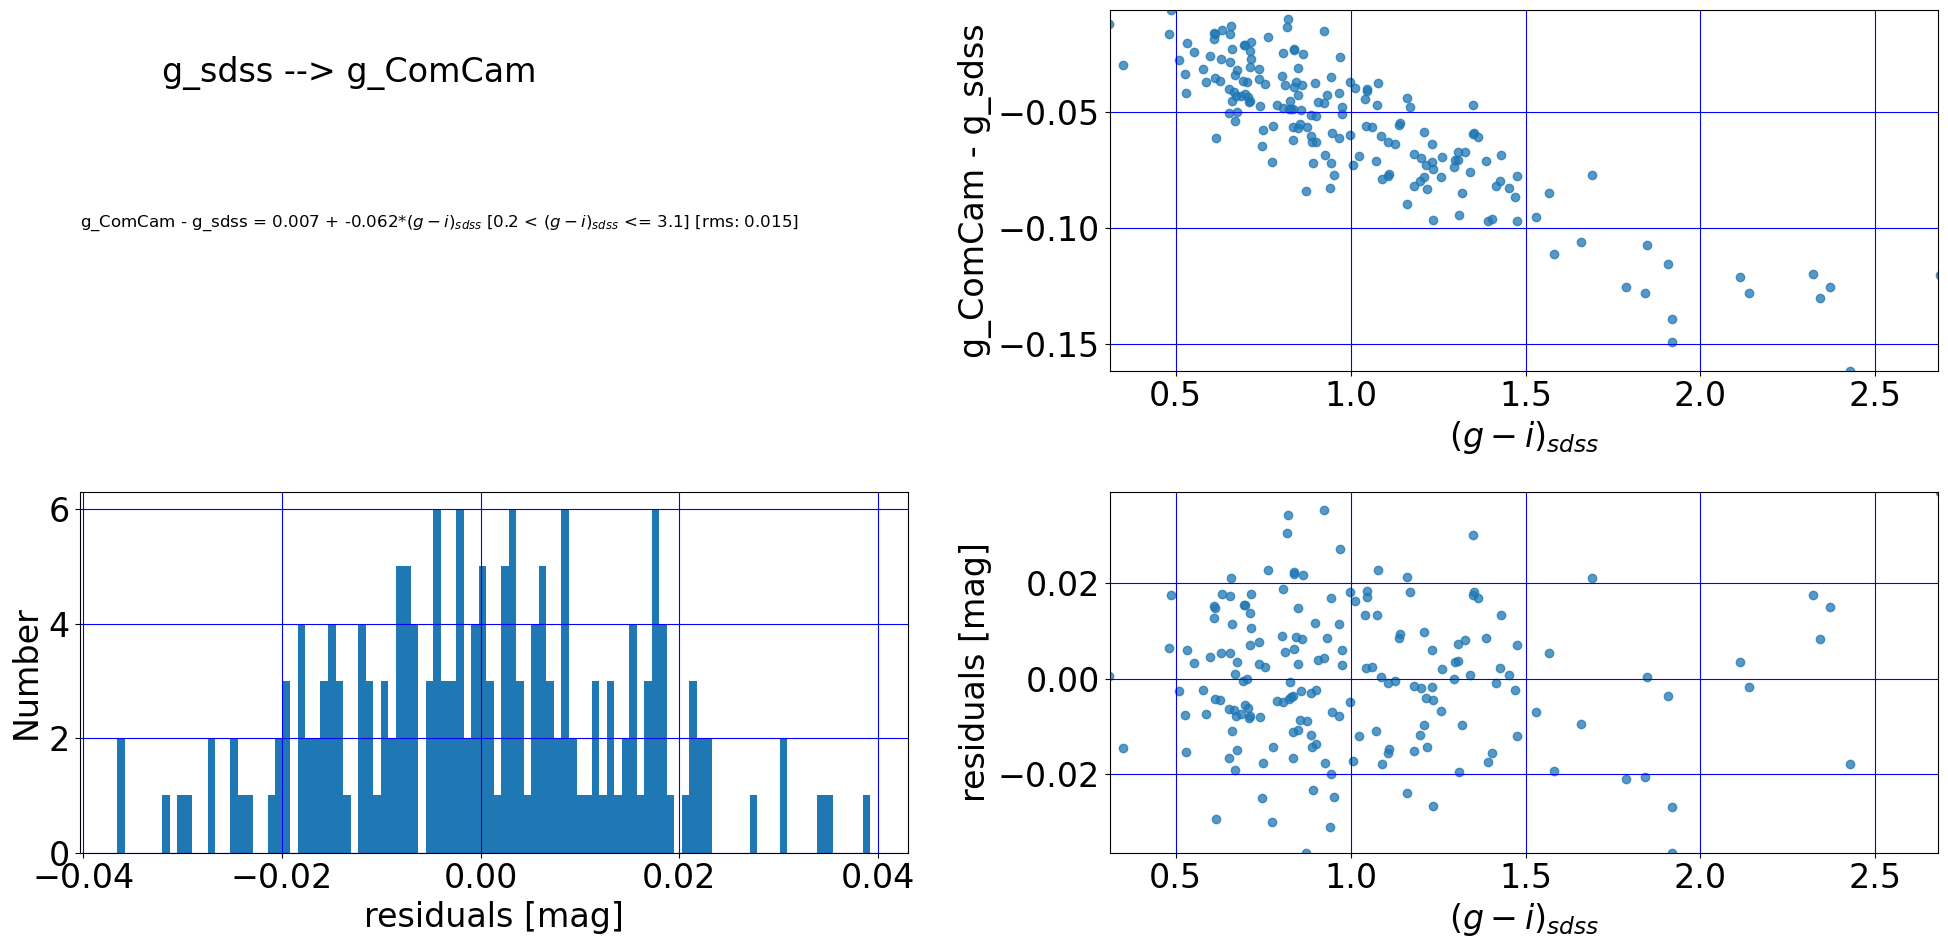

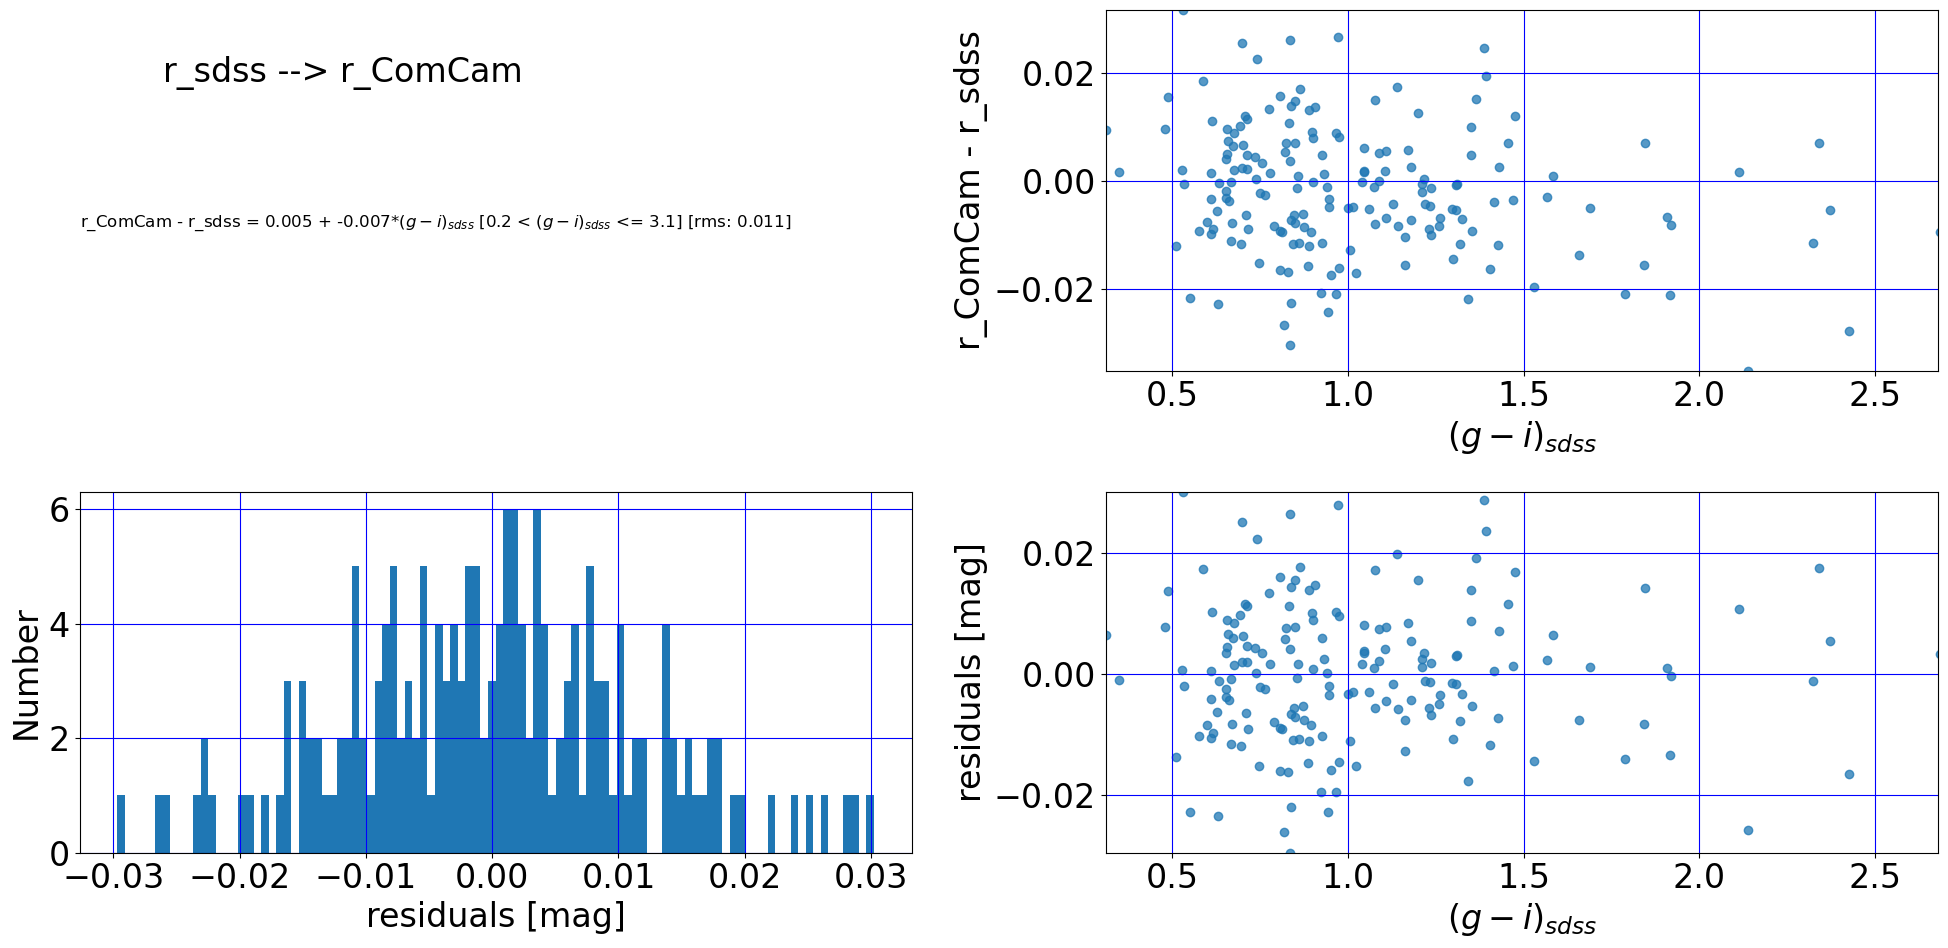

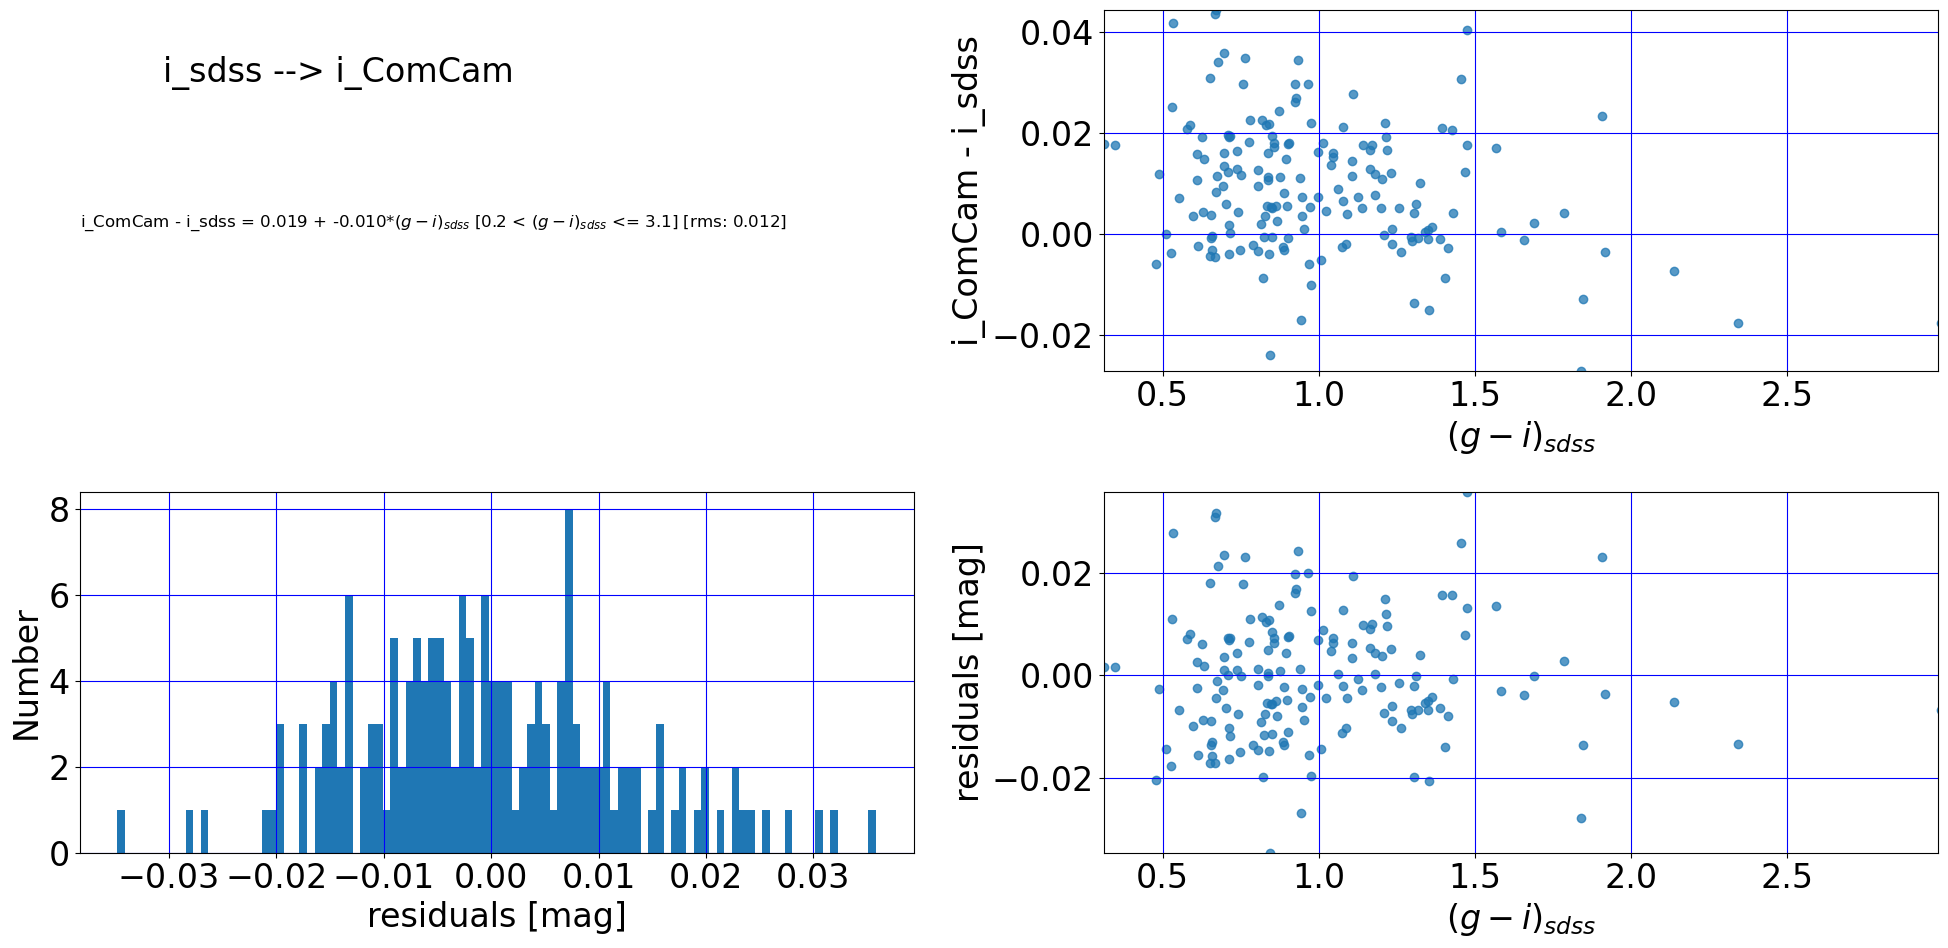

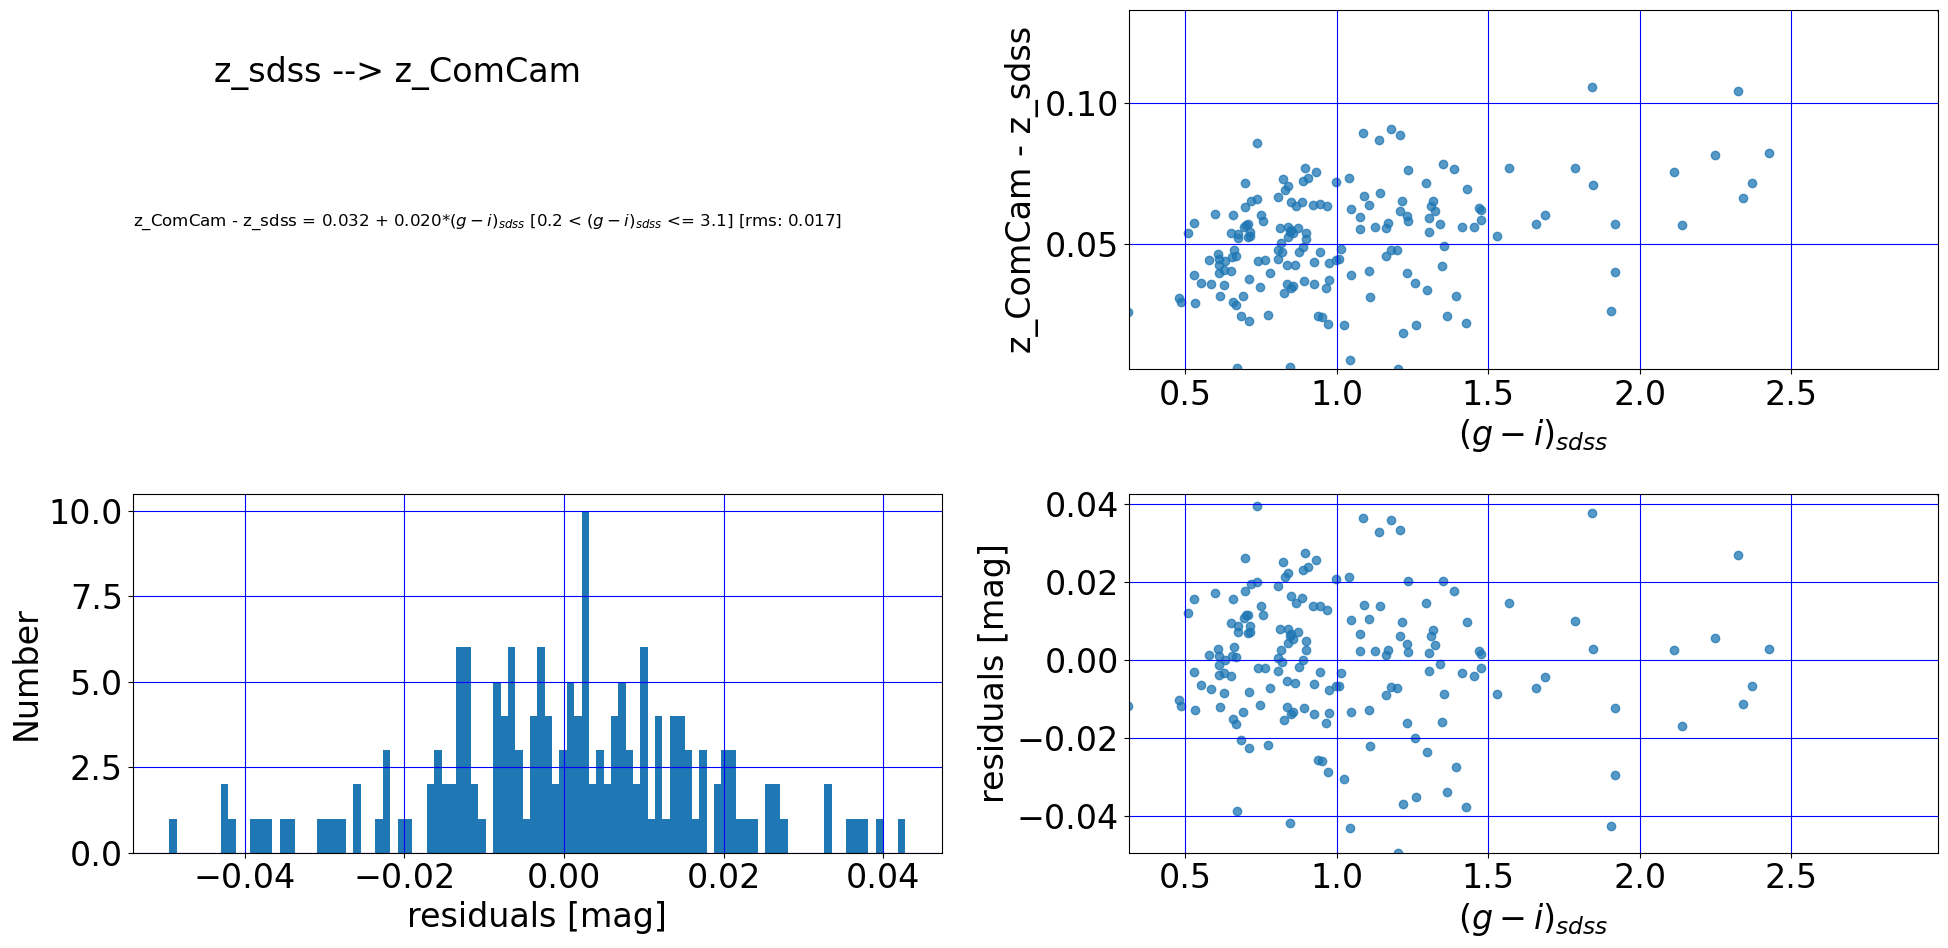

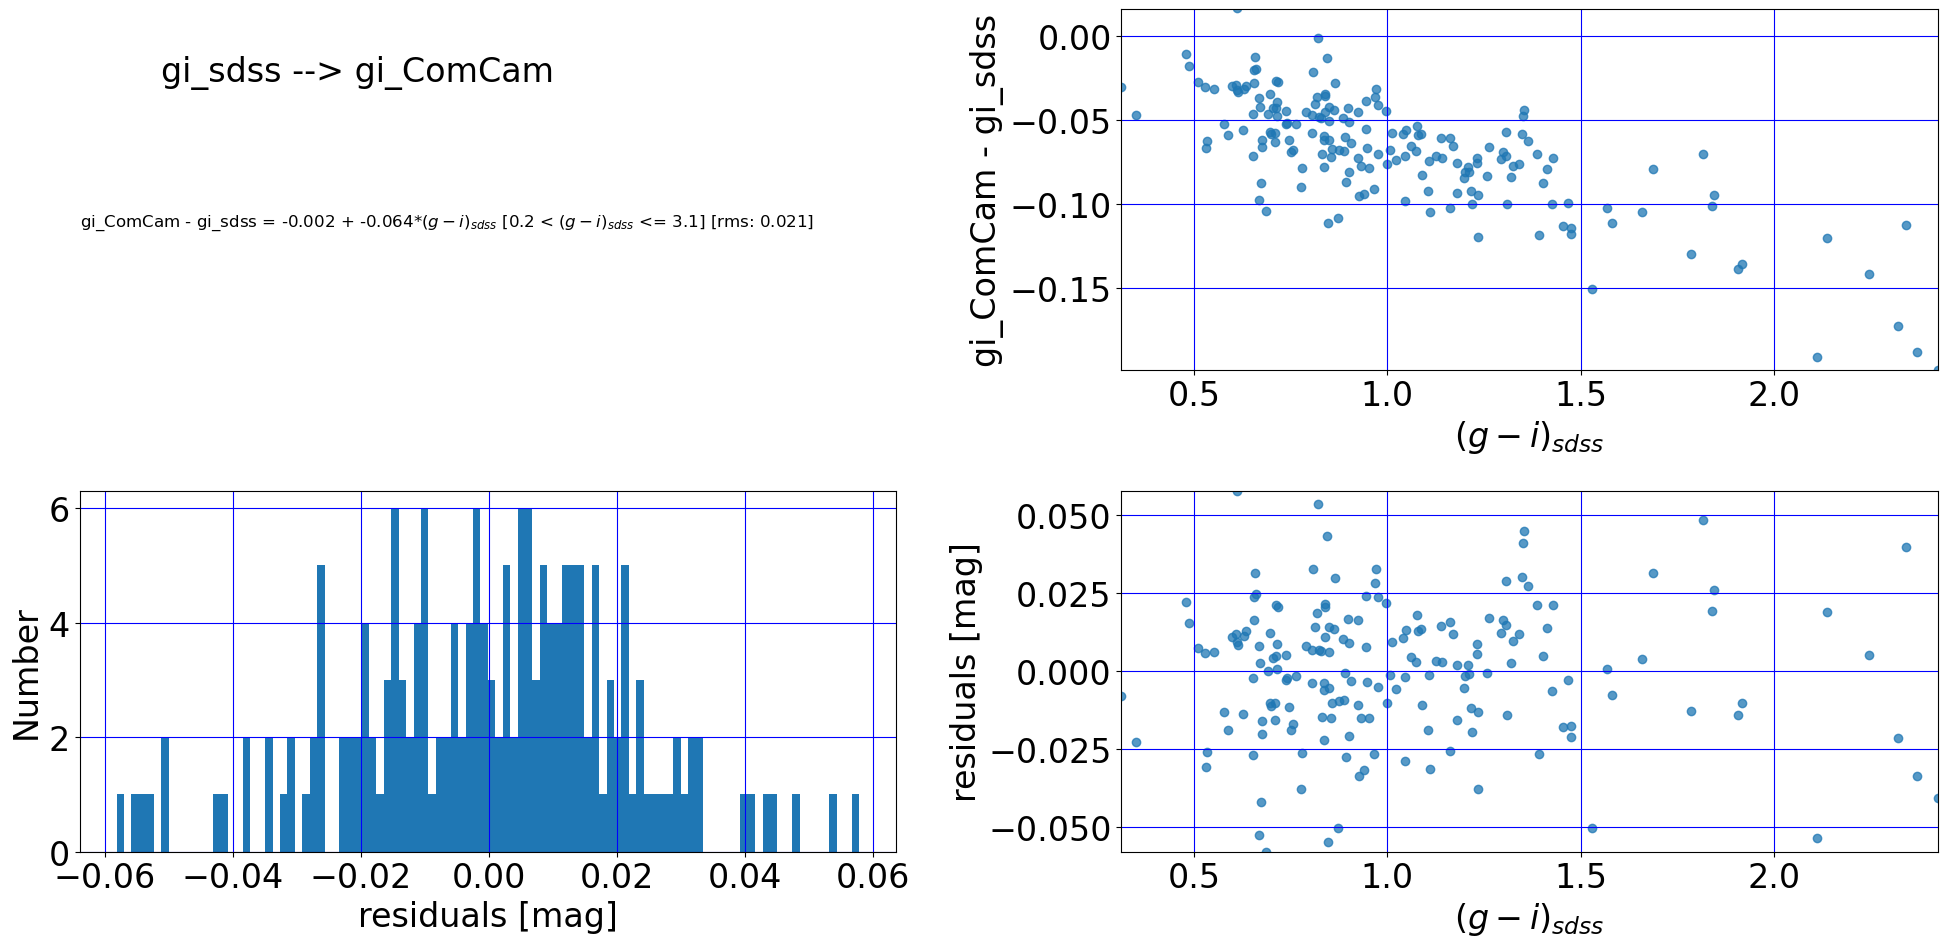

In [32]:
for band in bandList:

    print("")
    print("")
    print("")
    print("# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print(band)
    print("# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print("")

    magName = band
    magName_match = matchBand_dict[band]
    color_name_1 = color_name_1_dict[band]
    colorLabel_1 = colorLabel_1_dict[band]

    
    # Create title/names for use in QA plots...
    title = """%s --> %s""" % (magName_match, magName)
    dmagName = """%s - %s""" % (magName, magName_match)

    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column for {$band} - {$band}_match...
    df.loc[:,'dmag'] = df.loc[:,magName] - df.loc[:,magName_match]

    # Update mask...
    mask1 = ( abs(df['dmag']) <= 10. )
    mask2 = ( ( df[color_name_1] > -3. ) & ( df[color_name_1] < 6.0 ) & (df[color_name_1].notna()) )
    mask = mask & mask1 & mask2

    # Apply the new mask to df...
    df = df[mask]

    ## Sanity check
    #df.plot(color_name_1, 'dmag', kind='scatter')

    # Calculate number of disjoint branches to fit...
    nbranches = len(color_limits_1_dict[band]) - 1
    if verbose > 0: print(band, color_limits_1_dict[band], nbranches)

    
    # Reset bluest color limit in bluest branch to color1_min
    #  and reddest color limit in reddest branch to color1_max, 
    #  after excluding above mask...
    #dftmp = df[mask]
    dftmp = df
    color1_desc = dftmp[color_name_1].describe(percentiles=[0.0001, 0.9999])
    color1_min = math.floor(10*(color1_desc['0.01%']-0.05))/10.
    color1_max = math.ceil(10*(color1_desc['99.99%']+0.05))/10.
    color_limits_1_dict[band][0] = color1_min
    color_limits_1_dict[band][nbranches] = color1_max
    if verbose > 0: print(band, color_limits_1_dict[band], nbranches)

    p_branch_list = []
    
    # Iterate, with sigma-clipping...
    df_list = []
    color1_list = []
    dmag_list = []
    res_list = []
    mask_list = []
    plot1Text = ''
    outputLine = ''
        
    for ibranch in range(nbranches):
            
        print('*********************************')
        print(ibranch, color_limits_1_dict[band][ibranch], color_limits_1_dict[band][ibranch+1])
        print('*********************************')

        # Extract branch...
        mask_branch = ( (df[color_name_1] >  color_limits_1_dict[band][ibranch]) & \
                        (df[color_name_1] <= color_limits_1_dict[band][ibranch+1]) )

        df_branch = df[mask_branch].copy()

        # ... and extract dmag's and color1's for this branch...
        dmag_branch   = df_branch.loc[:,'dmag']
        color1_branch = df_branch.loc[:,color_name_1]

        # If there are no valid colors on this branch, continue to next branch...
        if len(color1_branch) < 1:
            continue
                
        # Perform fit for each disjoint branch...
        print("mask_branch length (before): " , len(mask_branch))
        print("dmag_branch length:  ", len(dmag_branch))
        print("color1_branch length:  ", len(color1_branch))
        p_branch, perr_branch, color1_branch, dmag_branch, res_branch, stddev_branch = \
                                poly_fit_with_sigma_clip(color1_branch, dmag_branch, degree=norder)
        print("mask_branch length (after): " , len(mask_branch))

        # Print coefficients and estimated statistical errors in the coefficients
        for i, (p, perr) in enumerate(zip(p_branch, perr_branch)):
            print(f'p_{len(p_branch)-i-1} = {p:.6f} ± {perr:.6f}')
      
        # Prepare some text output for plots...
        #  Recall that np.polyfit returns the coefficients from highest order to lowest
        #  (This is opposite of the order the coefficients in older versions of this notebook
        #   that did not use np.polyfit for the polynomial fits)
        if norder == 1:
            plot1Text1 = """%s = %.3f + %.3f*%s [%.1f < %s <= %.1f] [rms: %.3f]""" % \
                (dmagName, p_branch[1], p_branch[0], colorLabel_1, \
                 color_limits_1_dict[band][ibranch], colorLabel_1, color_limits_1_dict[band][ibranch+1], \
                 stddev_branch)
        elif norder == 2:
            plot1Text1 = """%s = %.3f + %.3f*%s + %.3f*%s^2  [%.1f < %s <= %.1f] [rms: %.3f]""" % \
                (dmagName, p_branch[2], p_branch[1], colorLabel_1, p_branch[0], colorLabel_1, \
                 color_limits_1_dict[band][ibranch], colorLabel_1, color_limits_1_dict[band][ibranch+1], \
                 stddev_branch)
        else:
            plot1Text1 = ''
            
        plot1Text = """%s\n%s""" % (plot1Text, plot1Text1)
        
        print(plot1Text1)                        
 
            
        # Append branch df and mask to the df_list and mask_list lists, respectively...
        #df_list.append(df_branch.copy())
        #mask_list.append(mask_branch.copy())
        color1_list.append(color1_branch.copy())
        dmag_list.append(dmag_branch.copy())
        res_list.append(res_branch.copy())
        mask_list.append(mask_branch.copy())
        
    # Concatenate the color1, dmag, res, and mask lists for all the branches...
    color1 = pd.Series(np.concatenate(color1_list))
    dmag = pd.Series(np.concatenate(dmag_list))
    res = pd.Series(np.concatenate(res_list))
    mask = pd.Series(np.concatenate(mask_list))
    
    # Calculate the standard deviation for the full piecewise fit...
    stddev = res.std()


    # Output best fits to screen...
    if verbose > 0:
        print("")
        print(title)
        print(plot1Text)
        print("")
    
    # Create QA plots...
    #res =  df.loc[:,'res']
    #dmag =  df.loc[:,'dmag']
    #color1 = df.loc[:,color_name_1]
    #stddev = df['res'].std()
    outputFileName = """%s.dmag_%s-%s.%s.norder%d.qa1.png""" % \
        (qaFileBaseName, magName, magName_match, color_name_1, norder)
    status = transform1ColorQAPlots1a(dmag, color1, res, norder, title, plot1Text, 
                                 dmagName, colorLabel_1, stddev, outputFileName)  
    
            



In [33]:
raise StopExecution

## 12.  Sandbox

In [ ]:
# Example with plotting
import matplotlib.pyplot as plt

band = 'g'

magName_ComCam = """%s_ComCam""" % (band)
magErrName_ComCam = """%s_err_ComCam""" % (band)
magName_ps1 = """%s_ps1""" % (band)
magErrName_ps1 = """%s_err_ps1""" % (band)
    
# Grab the original version of df from the backup copy...
df = df_orig.copy()

# Grab the original version of mask from the backup copy...
mask = mask_orig.copy()

# Update dmag column for {$band}_des - {$band}_ComCam...
if toComCam:
    df.loc[:,'dmag'] = df.loc[:,magName_ComCam] - df.loc[:,magName_ps1]
else:
    df.loc[:,'dmag'] = df.loc[:,magName_ps1] - df.loc[:,magName_ComCam]
        
# Update mask...
mask1 = abs(df['dmag']) <= 10.
mask2 = abs(df[magErrName_ComCam]) <= 0.02
mask3 = abs(df[magErrName_ps1]) <= 0.01
mask = mask & mask1 & mask2 & mask3

# make a copy of original df, overwriting the old one...
df = df[mask].copy()

# Identify dmag and color1 series...
dmag =  df.loc[:,'dmag']
color1 = df.loc[:,color_name_1]


color1_array = color1
dmag_array = dmag

# Perform the fit
coeffs, mask, res, rms = poly_fit_with_sigma_clip(color1_array, dmag_array, degree=1)

# Generate smooth curve for plotting
x_smooth = np.linspace(min(color1_array), max(color1_array), 100)
y_smooth = np.polyval(coeffs, x_smooth)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(color1_array[mask], dmag_array[mask], label='Used points')
plt.scatter(color1_array[~mask], dmag_array[~mask], color='red', label='Rejected points')
plt.plot(x_smooth, y_smooth, 'k-', label='Fit')
plt.xlabel('Color')
plt.ylabel('dmag')
plt.legend()
plt.title(f'Polynomial fit (RMS = {rms:.3f})')
plt.show()

# Print coefficients
for i, c in enumerate(coeffs):
    print(f'c_{len(coeffs)-i-1} = {c:.6f}')